### Load and process data

In [1]:
from utils.preprocess_helpers import *
from utils.eval_helpers import *
import os
import numpy as np

root_path = os.getcwd()

clouds = build_taj_clouds(root_path, verbose=True)

norm_clouds = {
    k: normalize_preserve_aspect(v)
    for k, v in clouds.items()
}

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
▶ Loading sparse and dense point clouds
   Sparse: 52,032 pts
   Dense : 2,431,918 pts
   done in 0.75s

▶ Cropping dense cloud to sparse bounding box
   Cropped dense: 2,376,339 pts
   done in 0.23s

▶ Fitting facade plane and aligning to Z+
   Plane aligned
   done in 1.46s

▶ Generating naive 4-way symmetry
   Symmetry generated
   done in 0.27s

▶ Running ICP alignment
   → ICP Left → Front
     done in 22.01s
   → ICP Right → Front
     done in 21.97s
   → ICP Back → Left
     done in 20.48s
   Final ICP cloud: 9,505,356 pts
   total ICP time: 64.62s

▶ Loading carved voxel grid
   Carved grid: 12,021,844 pts
   done in 2.50s

✅ Preprocessing complete

▶ Loading synthetic CAD mesh
   Synthetic CAD loaded and sampled
   done in 3.51s



### Visualize all point clouds together

▶ Building overlay visualization
   → Sparse (52,032 pts)
   → Dense (Cropped) (2,376,339 pts)
   → Completed (ICP Aligned) (9,505,356 pts)
   → Carved Grid (12,021,844 pts)
   → Synthetic Reference (CAD) (50,000 pts)


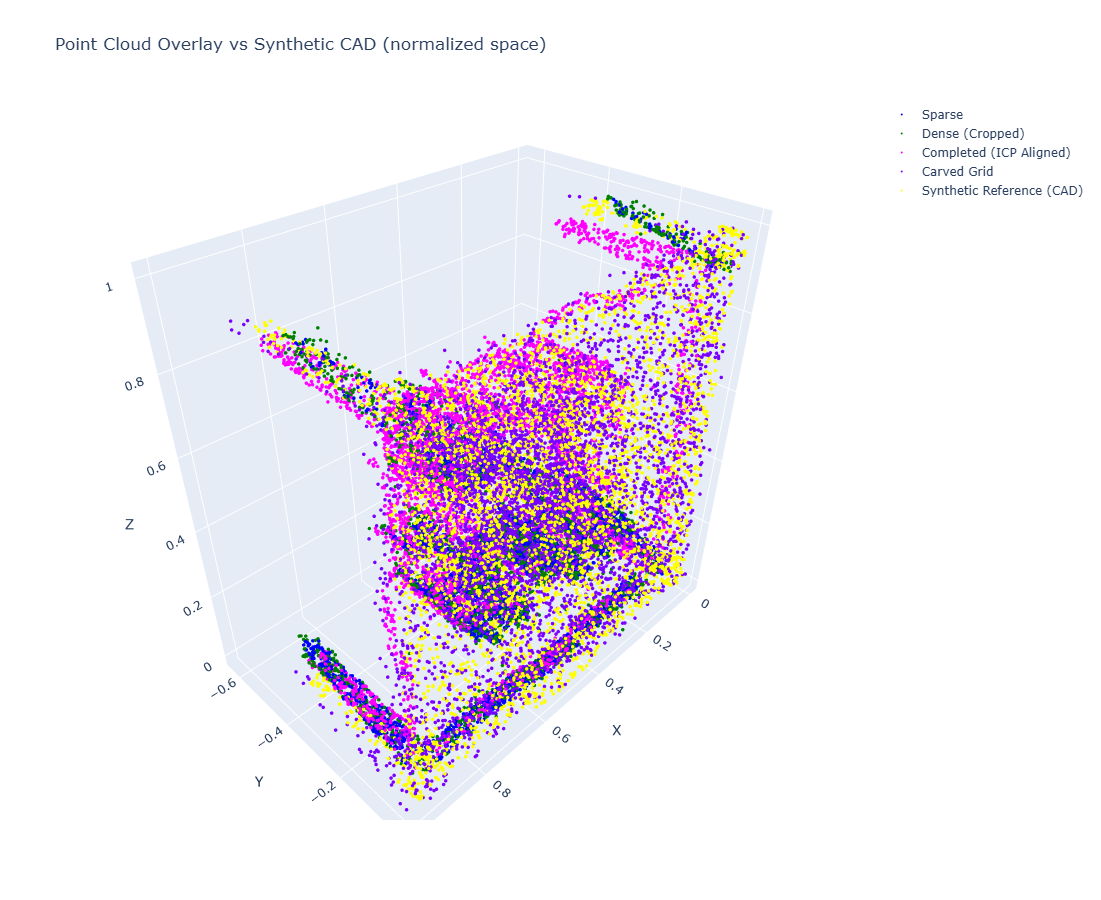

In [3]:
# ============================================================
# Overlay visualization: all point clouds together
# ============================================================

import plotly.graph_objects as go
import numpy as np

# how many points to show per method (visual only)
VISUAL_SAMPLE = 5000

# consistent colors (paper-friendly)
COLORS = {
    "Sparse": "blue",
    "Dense (Cropped)": "green",
    "Completed (ICP Aligned)": "magenta",
    "Carved Grid": "#7a00ff",
    "Synthetic Reference (CAD)": "yellow",
}

def downsample_vis(points, n=VISUAL_SAMPLE):
    if len(points) <= n:
        return points
    idx = np.random.choice(len(points), n, replace=False)
    return points[idx]

fig = go.Figure()

print("▶ Building overlay visualization")

for name, pts in norm_clouds.items():
    print(f"   → {name} ({len(pts):,} pts)")
    pts_ds = downsample_vis(pts)

    fig.add_trace(
        go.Scatter3d(
            x=pts_ds[:, 0],
            y=pts_ds[:, 1],
            z=pts_ds[:, 2],
            mode="markers",
            marker=dict(size=2, color=COLORS[name]),
            name=name
        )
    )

fig.update_layout(
    title="Point Cloud Overlay vs Synthetic CAD (normalized space)",
    scene=dict(
        aspectmode="data",
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    ),
    width=1200,
    height=900,
    showlegend=True,
)

fig.show()


### Evaluation metrics

In [2]:
# ============================================================
# FINAL INTER-METHOD METRICS TABLE (CANONICAL)
# ============================================================

import time
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# ----------------------------
# Display names (paper order)
# ----------------------------
METHODS = {
    "SfM": "Sparse",
    "MVS (without symm.)": "Dense (Cropped)",
    "MVS (with symm.)": "Completed (ICP Aligned)",
    "Proposed": "Carved Grid",
}

REF_NAME = "Synthetic Reference (CAD)"
ref_cloud = norm_clouds[REF_NAME]
tau = 0.03

rows = []
t0_global = time.time()

print("▶ Starting evaluation of all metrics\n")

# ============================================================
# Accuracy
# ============================================================
print("▶ Accuracy metrics")
for metric in ["Chamfer-L2 ↓", "Chamfer-L1 ↓", "PCA Similarity ↑"]:
    row = {"Category": "Accuracy", "Metric": metric}
    for disp, key in METHODS.items():
        cloud = norm_clouds[key]
        if metric == "Chamfer-L2 ↓":
            val = chamfer_distance(cloud, ref_cloud, squared=True)
        elif metric == "Chamfer-L1 ↓":
            val = chamfer_distance(cloud, ref_cloud, squared=False)
        else:
            val = pca_shape_similarity(cloud, ref_cloud)
        row[disp] = val
    rows.append(row)

# ============================================================
# Completeness
# ============================================================
print("▶ Completeness metrics")
for metric in ["Convex Volume ↑", "Point Density ↑", "Voxel IoU ↑"]:
    row = {"Category": "Completeness", "Metric": metric}
    for disp, key in METHODS.items():
        cloud = norm_clouds[key]
        hull = ConvexHull(cloud)
        if metric == "Convex Volume ↑":
            val = hull.volume
        elif metric == "Point Density ↑":
            val = len(cloud) / hull.volume
        else:
            val = voxel_iou(cloud, ref_cloud, resolution=64, dilate_frac=0.02)
        row[disp] = val
    rows.append(row)

# ============================================================
# Regularity
# ============================================================
print("▶ Regularity metrics")
for metric in ["NN Mean ↓", "NN Std ↓", "NN CV ↓"]:
    row = {"Category": "Regularity", "Metric": metric}
    for disp, key in METHODS.items():
        nn_stats = compute_nn_stats(norm_clouds[key])
        row[disp] = nn_stats[metric]
    rows.append(row)

# ============================================================
# Smoothness (fast, low-res marching cubes)
# ============================================================
print("▶ Smoothness metrics (marching cubes)")

smooth_cache = {}

for disp, key in METHODS.items():
    print(f"   → {disp}")
    verts, faces = get_marching_cubes_mesh(
        norm_clouds[key].astype(np.float32),
        grid_size=128,
        sigma=1.0
    )
    smooth_cache[disp] = compute_surface_metrics(verts, faces, k=20)

for metric in ["Normal StdDev (°)", "Mean Roughness (λ₃)", "Mean Curvature"]:
    row = {"Category": "Smoothness", "Metric": metric}
    for disp in METHODS.keys():
        row[disp] = smooth_cache[disp][metric]
    rows.append(row)

# ============================================================
# Final table
# ============================================================
df = pd.DataFrame(rows)

df_fmt = df.copy()
for c in METHODS.keys():
    df_fmt[c] = df_fmt[c].astype(float).map(lambda x: f"{x:.4g}")

print("\n=== FINAL INTER-METHOD METRICS TABLE ===")
print(df_fmt.to_string(index=False))

print(f"\n▶ Total runtime: {time.time() - t0_global:.2f}s")


▶ Starting evaluation of all metrics

▶ Accuracy metrics
▶ Completeness metrics
▶ Regularity metrics
▶ Smoothness metrics (marching cubes)
   → SfM
   → MVS (without symm.)
   → MVS (with symm.)
   → Proposed

=== FINAL INTER-METHOD METRICS TABLE ===
    Category              Metric       SfM MVS (without symm.) MVS (with symm.)  Proposed
    Accuracy        Chamfer-L2 ↓   0.02687             0.02083         0.004059 0.0007914
    Accuracy        Chamfer-L1 ↓    0.1481              0.1268          0.07076   0.03221
    Accuracy    PCA Similarity ↑    0.8038              0.9236           0.9404    0.9721
Completeness     Convex Volume ↑    0.3788              0.4439           0.4724    0.4787
Completeness     Point Density ↑ 1.374e+05           5.354e+06        2.012e+07 2.511e+07
Completeness         Voxel IoU ↑     0.146              0.2628           0.3296    0.8365
  Regularity           NN Mean ↓  0.001786            0.002169         0.003289  0.007698
  Regularity            NN St